Python Group
Lab Assignment Seven: RNNs
Wali Chaudhary, Bryce Shurts, & Alex Wright

# Business Understanding

The dataset is sourced from data.world on Kaggle, and is called "Emotion Detection from Text". It was distributed by data.world under a public license according to the source. The dataset is a collection of tweets annotated with emotions attached to each sample.

There exist 3 columns, "tweet_id", "sentiment", and "content". Tweet_id represents the identification number of the tweet for querying with the Twitter API, sentiment is the classification of emotion associated with the content, and content is the raw text from the tweet.

The dataset contains 13 different emotions, with 40000 records. The dataset is imbalanced, as there are a different number of records per emotion, so this must be addressed in preprocessing the data.


# Preparation


#### Splitting the data
We will be using Stratified K-Fold Cross Validation to split our data into training and testing sets. We chose this method based on the structure of our dataset.

The dataset contains imbalanced classes, so we want to ensure that the distribution of the training & testing sets are representative of the overall distribution of classes in the dataset and is beneficial to reducing bias. Features like the sentiment feature are imbalanced with each of the 13 values associated with it having a different distribution across the dataset. Stratified K-Fold Cross Validation ensures this proportionality of distribution, unlike a normal train test split which randomly splits the data into two sets based on a predefined ratio. This can result in a skewed representation of classes in the training & testing datasets not representative of the distribution of the entire dataset.

Stratified K-Fold Cross Validation also gives us the advantage of being able to compare different models as each model is trained differently per fold. This will help us in hyper parameter tuning.


#### Tokenization methods, Vocabulary, and content length

We use the Keras Tokenizer class to tokenize the text data in our dataset. We convert each tweet's text into a sequence of integers, where each integer represents a unique word in the vocabulary. The Tokenizer also takes care of lowercasing, removing punctuation, and handling out-of-vocabulary words.

We defined our vocabulary to use all the unique words in "content", this was because we didn't want to lose any data as we thought this would also generalize our model better overall. Although this will increase the complexity of our model, and one could also argue that mispellings and grammatical errors can lead to an incorrect classification; we believe that grammatical errors and slang are common ways of emotional expression online. For example, if a user tweets GAAAAAHHHH, that probably means they're very upset versus someone who tweets GAH which may indicate surprise.

We decided to keep the length of each sequence to the longest individual sequence by using padding, as this'll help us capture the maximum amount of input for sentiment analysis.


#### Evaluation Metrics

For evaluation, we decided to rely on the F1 score, precision, recall, and accuracy. This is because we are performing a classification task on sequences to predict sentiment. Precision is important because it helps us guage the our models True positive predictiveness, and recall helps us identify the number of positive instances correctly identified out of the total amount of positive cases. In our specific case, recall is important because it'll tell us the ratio of how much our classifier was able to identify correct sentiment, like happiness, out the all of the happiness records. Precision will tell us if our evaluation of sentiment was correct.

The F1 score balances both of these metrics together, and provides a balanced measure of our models performance. In sentiment analysis, false positives and false negatives are not good because both types of errors can have significant consequences, especially in a system which relies on the classification to provide recommendations or critical information. A high F1-score indicates that our model is making accurate positive predictions while minimizing false positives and false negatives. It is also useful in our case as well since our dataset is imbalanced, because it reduces bias to the majority class by giving a balanced result of the recall and precision to account for both false positives and false negatives.

In [30]:
# Handle all imports for notebook

import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from os import listdir
from os.path import isfile, join
from skimage.transform import resize
from sklearn import preprocessing
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers import CuDNNGRU
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# from keras.utils import pad_sequences
from sklearn.preprocessing import OneHotEncoder

In [31]:
df = pd.read_csv("tweet_emotions.csv")

In [32]:
df.dropna(axis=0, inplace=True)
df.drop("tweet_id", inplace=True, axis=1)

df.groupby(df["sentiment"]).describe()

content                                                            \
             count unique                                                top   
sentiment                                                                      
anger          110    110                              fuckin'm transtelecom   
boredom        179    179                                       i'm so tired   
empty          827    827  @tiffanylue i know  i was listenin to bad habi...   
enthusiasm     759    759               wants to hang out with friends SOON!   
fun           1776   1776  Wondering why I'm awake at 7am,writing a new s...   
happiness     5209   5194  FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...   
hate          1323   1323  It is so annoying when she starts typing on he...   
love          3842   3801  I just received a mothers day card from my lov...   
neutral       8638   8617  FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...   
relief        1526   1524  http://snipurl.com/hq0n1 Just printed my mom a...   
sadness       5165   5160                                       at home sick   
surprise      2187   2187                                       Got the news   
worry         8459   8452                                  i have a headache   

                 
           freq  
sentiment        
anger         1  
boredom       1  
empty         1  
enthusiasm    1  
fun           1  
happiness     4  
hate          1  
love         13  
neutral       4  
relief        2  
sadness       2  
surprise      1  
worry         3

This shows us that the sentiment feature is very imbalanced, with each of its 13 values having a different distribution across the dataset. The highest value, happiness with 5209 in count is significantly higher than the lowest count, anger, which has only 110 records.

Dropped the "twitter_id" column as that was not relevant to the task at hand for classifying sentiment.

In [33]:
# Define the Stratified Shuffle Split object
n_splits = 3
test_size = 0.2
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

X, y = df.drop("sentiment", inplace=False, axis=1), df["sentiment"]

In [34]:
#tokenize the text, use entire vocabulary
tokenizer = Tokenizer()
y_np = y.to_numpy().reshape(-1, 1)

# save as sequences with integers replacing words
tokenizer.fit_on_texts(X["content"])
sequences = tokenizer.texts_to_sequences(X["content"])
final_seqs = pad_sequences(sequences,maxlen=300)
num_vocab = len(tokenizer.word_index)+1

encoder = OneHotEncoder(handle_unknown='ignore')
target = encoder.fit_transform(y_np).toarray()

In [35]:
# Load in the word embeddings
word_vectors = {}
for line in open("glove.840B.300d.txt"):
    value = line.split(' ')
    word_vectors[value[0]] = np.array(value[1:],dtype = 'float32')

# Apply embeddings to dataset
embedding_matrix_glove = np.zeros((num_vocab, 300))
for word, index in tokenizer.word_index.items():
    embedding = word_vectors.get(word)
    if embedding is not None:
        embedding_matrix_glove[index] = embedding

In [36]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot the training and validation accuracy vs training iterations
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot the training and validation loss vs training iterations
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Epoch 1/5
100/100 [==============================] - 10s 68ms/step - loss: 2.1183 - accuracy: 0.2731 - val_loss: 1.9968 - val_accuracy: 0.3206
Epoch 2/5
100/100 [==============================] - 6s 63ms/step - loss: 1.9153 - accuracy: 0.3464 - val_loss: 1.9212 - val_accuracy: 0.3403
Epoch 3/5
100/100 [==============================] - 6s 63ms/step - loss: 1.8579 - accuracy: 0.3653 - val_loss: 1.8999 - val_accuracy: 0.3477
Epoch 4/5
100/100 [==============================] - 6s 63ms/step - loss: 1.8218 - accuracy: 0.3771 - val_loss: 1.8934 - val_accuracy: 0.3516
Epoch 5/5
250/250 [==============================] - 3s 12ms/step


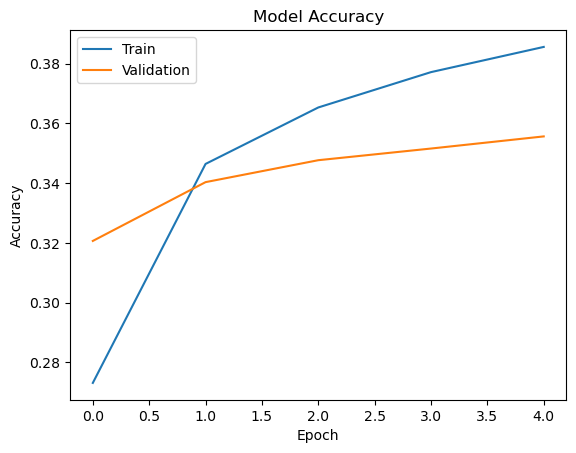

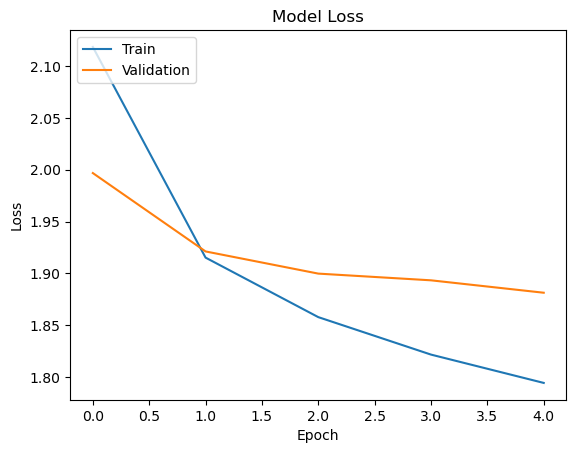

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.51      0.08      0.14      1042
           6       0.00      0.00      0.00       265
           7       0.65      0.20      0.30       768
           8       0.54      0.05      0.09      1728
           9       0.00      0.00      0.00       305
          10       0.45      0.03      0.05      1033
          11       0.00      0.00      0.00       437
          12       0.54      0.10      0.17      1692

   micro avg       0.56      0.07      0.12      8000
   macro avg       0.21      0.04      0.06      8000
weighted avg       0.42      0.07      0.11      8000
 samples avg       0.07      0.07      0.07      8000

Epoch 1/5
100/100 [======

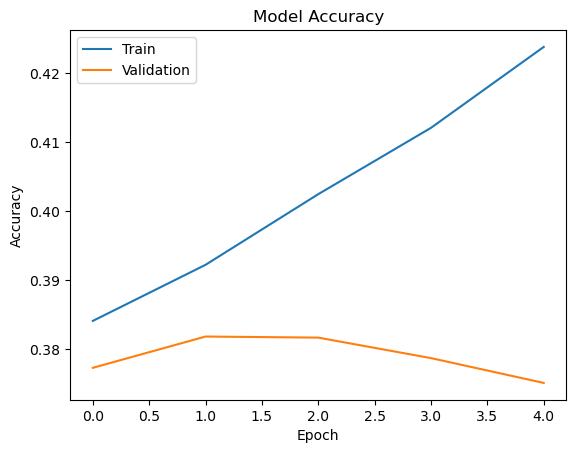

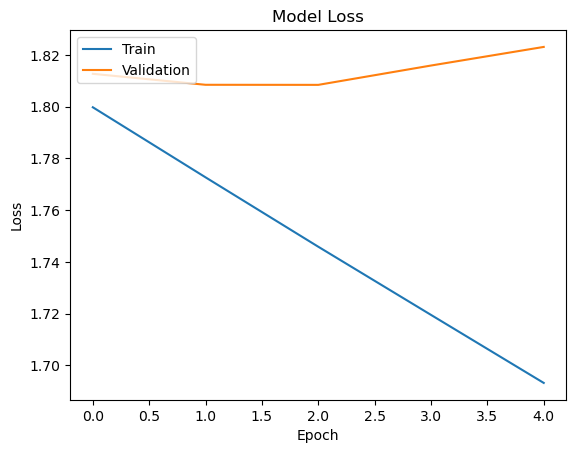

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.51      0.05      0.10      1042
           6       0.50      0.01      0.02       265
           7       0.60      0.31      0.41       768
           8       0.54      0.25      0.34      1728
           9       0.00      0.00      0.00       305
          10       0.46      0.12      0.20      1033
          11       0.00      0.00      0.00       437
          12       0.52      0.16      0.24      1692

   micro avg       0.54      0.14      0.22      8000
   macro avg       0.24      0.07      0.10      8000
weighted avg       0.43      0.14      0.20      8000
 samples avg       0.14      0.14      0.14      8000

Epoch 1/5
100/100 [======

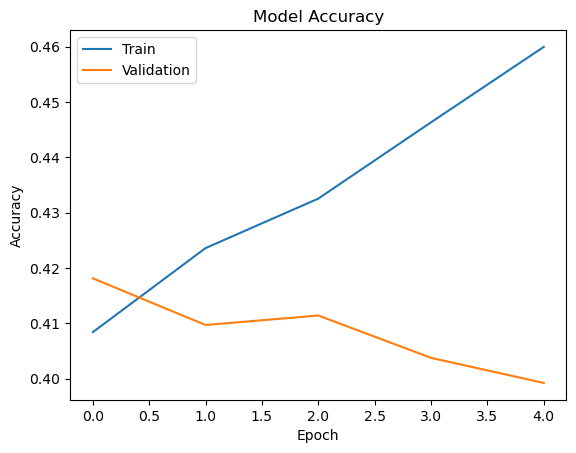

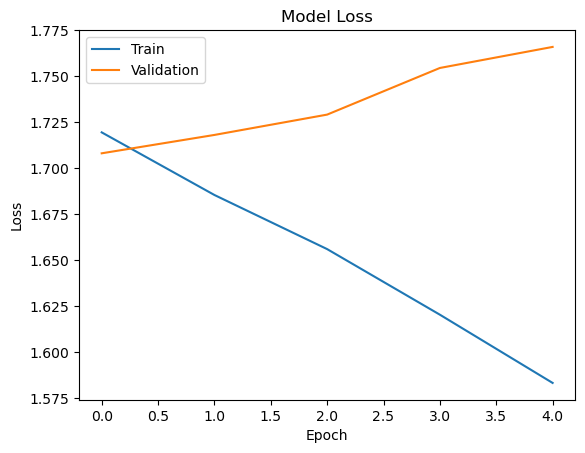

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.49      0.10      0.17      1042
           6       0.55      0.14      0.22       265
           7       0.62      0.38      0.47       768
           8       0.58      0.22      0.32      1728
           9       0.00      0.00      0.00       305
          10       0.51      0.14      0.22      1033
          11       0.39      0.02      0.04       437
          12       0.53      0.19      0.28      1692

   micro avg       0.55      0.16      0.25      8000
   macro avg       0.28      0.09      0.13      8000
weighted avg       0.47      0.16      0.23      8000
 samples avg       0.16      0.16      0.16      8000



In [37]:
# LSTM RNN
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(num_vocab, 300, weights=[embedding_matrix_glove], input_length=300, trainable=False))
model_bi_lstm.add(Bidirectional(CuDNNLSTM(75)))
model_bi_lstm.add(Dense(32, activation="relu"))
model_bi_lstm.add(Dense(13, activation="softmax"))
model_bi_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Default padding is to the longest sequence
for train_index, test_index in sss.split(sequences, target):
    X_train, X_test = final_seqs[train_index], final_seqs[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # hist = model_bi_lstm.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)
    hist = model_bi_lstm.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)
    y_pred = np.rint(model_bi_lstm.predict(X_test))
    plot_history(hist)
    print(classification_report(y_test, y_pred, zero_division=0))

Epoch 1/5
100/100 [==============================] - 9s 65ms/step - loss: 2.1715 - accuracy: 0.2586 - val_loss: 2.0121 - val_accuracy: 0.3103
Epoch 2/5
100/100 [==============================] - 6s 61ms/step - loss: 1.9296 - accuracy: 0.3431 - val_loss: 1.9091 - val_accuracy: 0.3531
Epoch 3/5
100/100 [==============================] - 6s 61ms/step - loss: 1.8486 - accuracy: 0.3702 - val_loss: 1.8800 - val_accuracy: 0.3503
Epoch 4/5
100/100 [==============================] - 6s 61ms/step - loss: 1.8057 - accuracy: 0.3841 - val_loss: 1.8611 - val_accuracy: 0.3605
Epoch 5/5
250/250 [==============================] - 3s 12ms/step


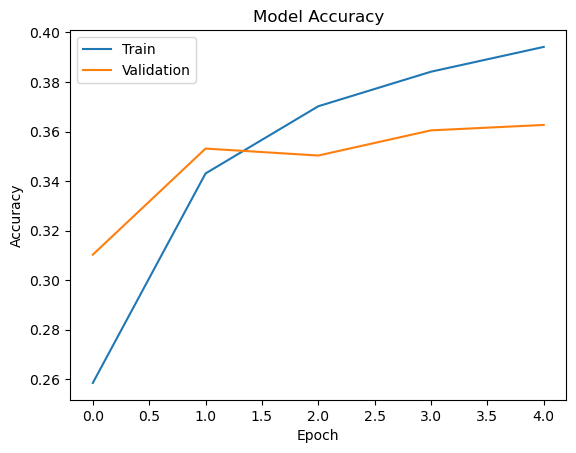

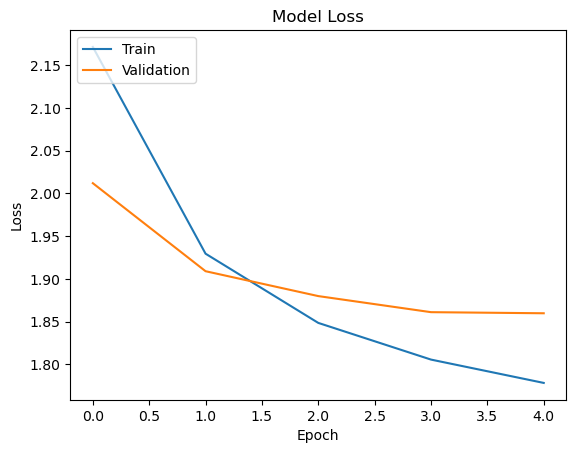

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.49      0.06      0.11      1042
           6       0.34      0.04      0.07       265
           7       0.67      0.18      0.29       768
           8       0.57      0.09      0.16      1728
           9       0.00      0.00      0.00       305
          10       0.54      0.04      0.07      1033
          11       0.00      0.00      0.00       437
          12       0.49      0.15      0.23      1692

   micro avg       0.54      0.08      0.14      8000
   macro avg       0.24      0.04      0.07      8000
weighted avg       0.44      0.08      0.14      8000
 samples avg       0.08      0.08      0.08      8000

Epoch 1/5
100/100 [======

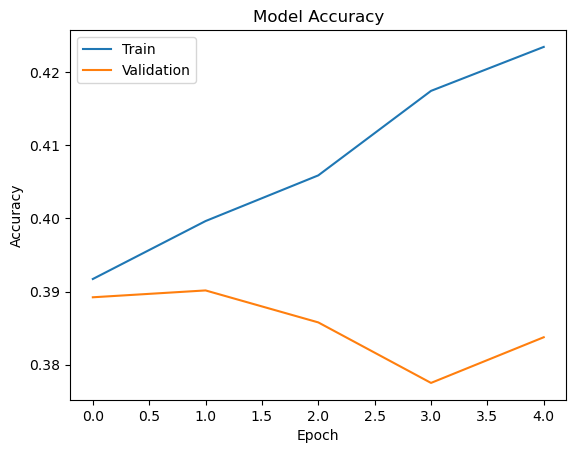

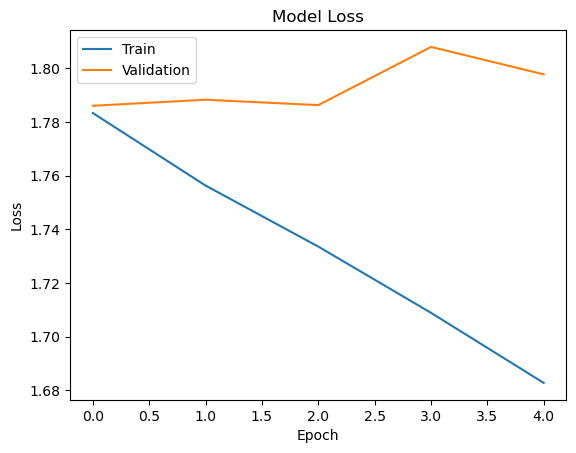

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.49      0.09      0.15      1042
           6       0.54      0.14      0.22       265
           7       0.60      0.26      0.37       768
           8       0.53      0.22      0.31      1728
           9       0.00      0.00      0.00       305
          10       0.49      0.14      0.21      1033
          11       0.00      0.00      0.00       437
          12       0.57      0.12      0.19      1692

   micro avg       0.54      0.13      0.21      8000
   macro avg       0.25      0.07      0.11      8000
weighted avg       0.44      0.13      0.20      8000
 samples avg       0.13      0.13      0.13      8000

Epoch 1/5
100/100 [======

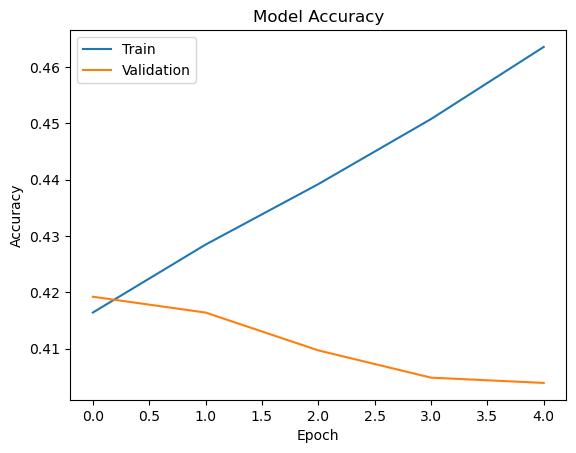

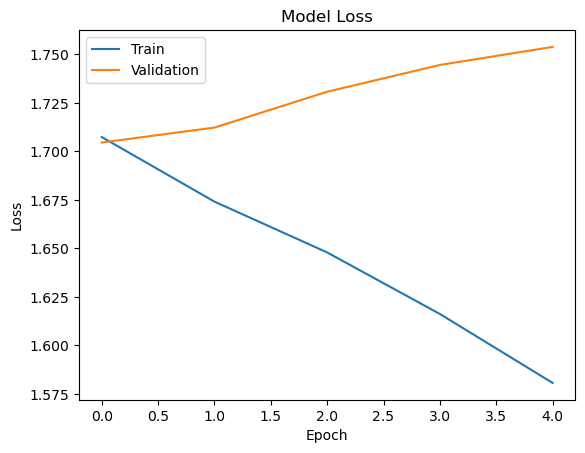

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.49      0.17      0.25      1042
           6       0.63      0.09      0.16       265
           7       0.65      0.32      0.43       768
           8       0.54      0.29      0.38      1728
           9       0.67      0.01      0.03       305
          10       0.44      0.21      0.28      1033
          11       1.00      0.00      0.00       437
          12       0.57      0.20      0.30      1692

   micro avg       0.54      0.19      0.28      8000
   macro avg       0.38      0.10      0.14      8000
weighted avg       0.52      0.19      0.26      8000
 samples avg       0.19      0.19      0.19      8000



In [38]:
# GRU RNN
model_gru = Sequential()
model_gru.add(Embedding(num_vocab, 300, weights=[embedding_matrix_glove], input_length=300, trainable=False))
model_gru.add(Bidirectional(CuDNNGRU(75)))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(13, activation="softmax"))
model_gru.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Default padding is to the longest sequence
for train_index, test_index in sss.split(sequences, target):
    X_train, X_test = final_seqs[train_index], final_seqs[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # hist = model_bi_lstm.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)
    hist = model_gru.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)
    y_pred = np.rint(model_gru.predict(X_test))
    plot_history(hist)
    print(classification_report(y_test, y_pred, zero_division=0))

# Numberbatch

In [39]:
# Load in the word embeddings
word_vectors = {}
for line in open("numberbatch-en.txt"):
    value = line.split(' ')
    word_vectors[value[0]] = np.array(value[1:],dtype = 'float32')

# Apply embeddings to dataset
embedding_matrix_numberbatch = np.zeros((num_vocab, 300))
for word, index in tokenizer.word_index.items():
    embedding = word_vectors.get(word)
    if embedding is not None:
        embedding_matrix_numberbatch[index] = embedding

Epoch 1/5
100/100 [==============================] - 10s 68ms/step - loss: 2.1833 - accuracy: 0.2354 - val_loss: 2.1183 - val_accuracy: 0.2594
Epoch 2/5
100/100 [==============================] - 6s 63ms/step - loss: 2.0226 - accuracy: 0.3045 - val_loss: 2.0598 - val_accuracy: 0.3008
Epoch 3/5
100/100 [==============================] - 6s 63ms/step - loss: 1.9488 - accuracy: 0.3353 - val_loss: 1.9567 - val_accuracy: 0.3298
Epoch 4/5
100/100 [==============================] - 6s 63ms/step - loss: 1.8950 - accuracy: 0.3523 - val_loss: 1.9179 - val_accuracy: 0.3425
Epoch 5/5
250/250 [==============================] - 3s 12ms/step


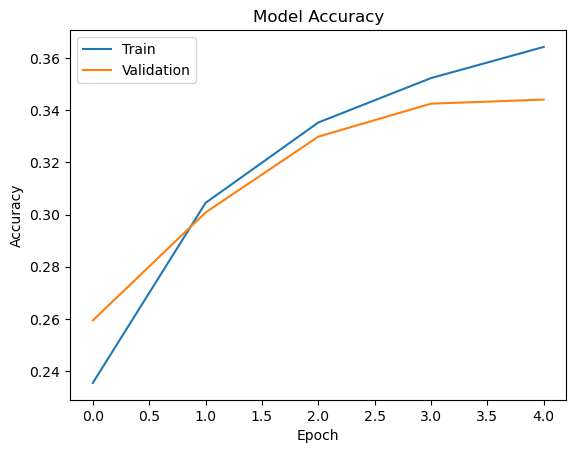

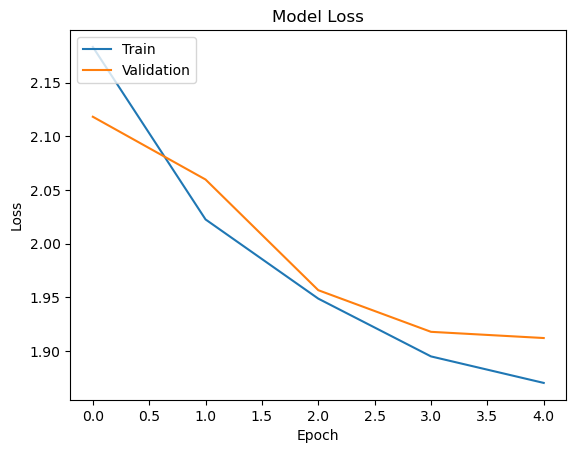

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.46      0.04      0.08      1042
           6       0.00      0.00      0.00       265
           7       0.70      0.13      0.21       768
           8       0.54      0.13      0.20      1728
           9       0.00      0.00      0.00       305
          10       0.57      0.01      0.02      1033
          11       0.00      0.00      0.00       437
          12       0.40      0.00      0.00      1692

   micro avg       0.56      0.05      0.08      8000
   macro avg       0.21      0.02      0.04      8000
weighted avg       0.40      0.05      0.08      8000
 samples avg       0.05      0.05      0.05      8000

Epoch 1/5
100/100 [======

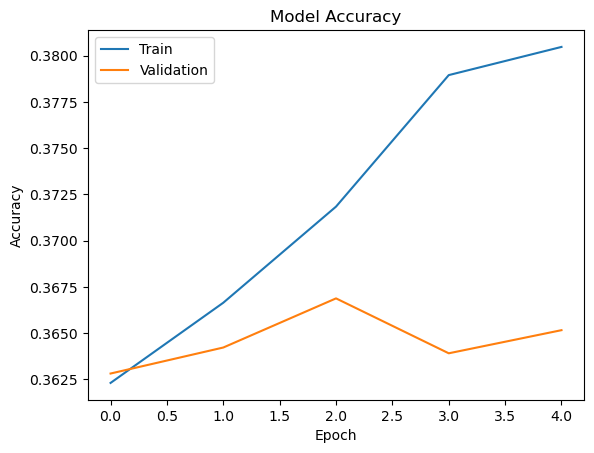

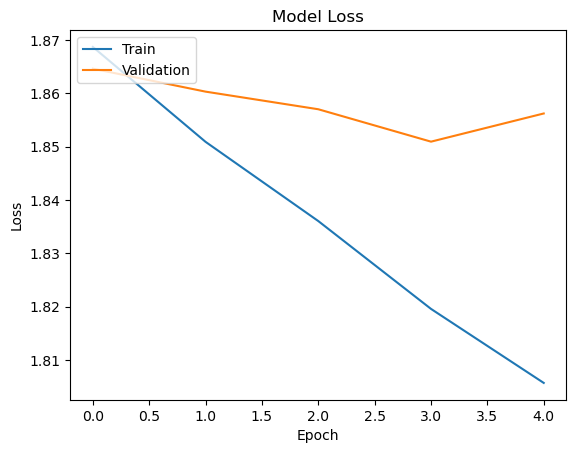

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.68      0.01      0.02      1042
           6       1.00      0.01      0.01       265
           7       0.61      0.29      0.39       768
           8       0.56      0.08      0.14      1728
           9       0.00      0.00      0.00       305
          10       0.48      0.10      0.16      1033
          11       0.00      0.00      0.00       437
          12       0.64      0.03      0.05      1692

   micro avg       0.57      0.07      0.12      8000
   macro avg       0.31      0.04      0.06      8000
weighted avg       0.50      0.07      0.10      8000
 samples avg       0.07      0.07      0.07      8000

Epoch 1/5
100/100 [======

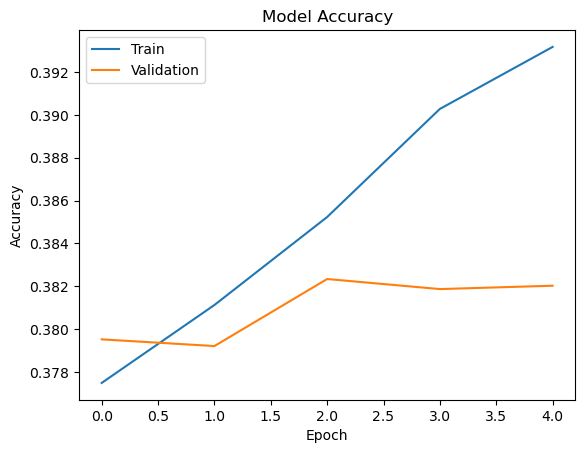

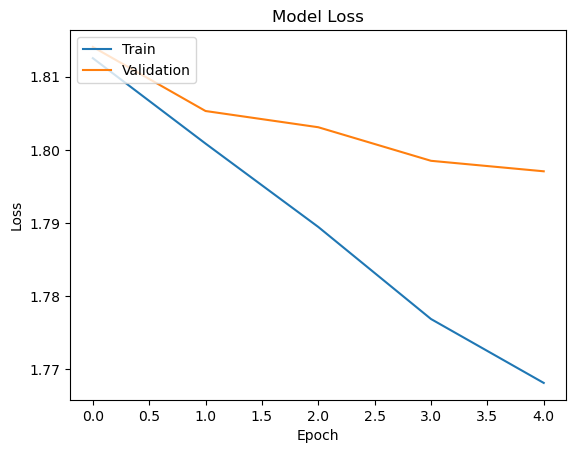

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       355
           5       0.48      0.04      0.08      1042
           6       0.49      0.10      0.16       265
           7       0.63      0.28      0.39       768
           8       0.54      0.17      0.26      1728
           9       0.00      0.00      0.00       305
          10       0.53      0.06      0.11      1033
          11       0.00      0.00      0.00       437
          12       0.59      0.11      0.19      1692

   micro avg       0.57      0.10      0.18      8000
   macro avg       0.25      0.06      0.09      8000
weighted avg       0.45      0.10      0.16      8000
 samples avg       0.10      0.10      0.10      8000



In [40]:
# LSTM RNN
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(num_vocab, 300, weights=[embedding_matrix_numberbatch], input_length=300, trainable=False))
model_bi_lstm.add(Bidirectional(CuDNNLSTM(75)))
model_bi_lstm.add(Dense(32, activation="relu"))
model_bi_lstm.add(Dense(13, activation="softmax"))
model_bi_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Default padding is to the longest sequence
for train_index, test_index in sss.split(sequences, target):
    X_train, X_test = final_seqs[train_index], final_seqs[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # hist = model_bi_lstm.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)
    hist = model_bi_lstm.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)
    y_pred = np.rint(model_bi_lstm.predict(X_test))
    plot_history(hist)
    print(classification_report(y_test, y_pred, zero_division=0))